# Определение перспективного тарифа для телеком компании

Необходимо сделать предварительный анализ тарифов на небольшой выборке клиентов. В вашем распоряжении данные 500 пользователей «Мегалайна»: кто они, откуда, каким тарифом пользуются, сколько звонков и сообщений каждый отправил за 2018 год. Нужно проанализировать поведение клиентов и сделать вывод — какой тариф лучше.

0. [Подготовка библиотек, функций](#paragraph0)
1. [Изучение данных](#paragraph1)
2. [Подготовка данных](#paragraph2)
3. [Анализ данных](#paragraph3)
4. [Проверка гипотез](#paragraph4)
5. [Вывод](#paragraph5)

<a name="paragraph0"></a>
## 0. Подготовка библиотек, функций

Импортируем библиотеки

In [126]:
from IPython.display import display
import pandas as pd

import math 
import numpy as np
from scipy import stats as st

import seaborn as sns
import matplotlib.pyplot as plt
import altair as alt # https://altair-viz.github.io/index.html

from scipy.stats import levene
from scipy.stats import bartlett

## Функции

### 0.1  sns_hist

In [127]:
def sns_hist(series:pd.Series, title:str, ox_label:str, bins = 50):
    """
    Функция для отображения распределения исследуемой величины
    series - Исследуемый набор данных 
    title - заголовок 
    ox_label - подпись оси Ox
    """
    plt.figure(figsize=(10,5))
    #sns.distplot(series)
    sns.histplot(series, kde=True, stat = 'probability', bins=bins)
    plt.axvline(series.median())
    plt.xlabel(ox_label, fontsize=16)
    plt.ylabel('Вероятность', fontsize=16)
    plt.title(title, fontsize=20)
    #rcParams['axes.titlepad'] = 0

### 0.2  alt_value_counts

In [128]:
def alt_value_counts(df:pd.DataFrame, col:str, title:str):
    """
    Функция для отображения уникальных значений столбца и общего количества значений по каждому уникальному значению
    df - DataFrame. Данные для анализа
    col - наименование колонки, информацию о которой необходимо отобразить.
    title - Заголовок графика
    """
    series_info = df.groupby(col)[col].count()
    data_info = pd.DataFrame({col:series_info.index, 'Количество':series_info.values})
    
    bars = alt.Chart(data_info, title = title).mark_bar().encode(
        x='Количество:Q',
        y=col + ":O"
    )

    text = bars.mark_text(
        align='left',
        baseline='middle',
        dx=3  # Nudges text to right so it doesn't appear on top of the bar
    ).encode(
        text='Количество:Q'
    )

    return (bars + text).properties(height = len(series_info) * 20)

### 0.3 side_by_side_hist

In [129]:
def side_by_side_hist(series_1:pd.Series, series_2:pd.Series, title:str, ox_label:str, legend:list, figsize:tuple=(11,6), bins = 20):
    """
    Функция выводящая сравнение распределений двух наборов данных
    series_1: первый набор данных, который участвует в сравнении
    series_2: второй набор данных, который участвует в сравнении
    title: заголовок
    ox_label: подпись оси Ox
    legend: легенда
    """
    plt.figure(figsize=figsize)
    sns.histplot(series_1, color = '#f8d568', kde=True, stat = 'probability', bins=bins)
    sns.histplot(series_2, color = '#18a7b5', kde=True, stat = 'probability', bins=bins)
    
    plt.axvline(series_1.median(), color = '#f8d568')
    plt.axvline(series_2.median(), color = '#18a7b5')
    
    plt.ylabel('Плотность', fontsize=14)
    plt.xlabel(ox_label, fontsize=16)
    plt.legend(legend, fontsize=18)
    plt.title(title, fontsize=20)

<a name="paragraph1"></a>
## 1. Изучение данных

Откроем файлы с данными

    Таблица data_calls (информация о звонках)
    Таблица data_users (информация о пользователях)
    Таблица data_messages (информация о сообщениях)
    Таблица data_internet (информация об интернет-сессиях)
    Таблица data_tariffs (информация о тарифах)

In [130]:
data_calls = pd.read_csv('datasets/calls.csv')
data_users = pd.read_csv('datasets/users.csv')
data_messages = pd.read_csv('datasets/messages.csv')
data_internet = pd.read_csv('datasets/internet.csv')
data_tariffs = pd.read_csv('datasets/tariffs.csv')

Начнем изучать данные с информации о звонках

In [131]:
data_calls.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 202607 entries, 0 to 202606
Data columns (total 4 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   id         202607 non-null  object 
 1   call_date  202607 non-null  object 
 2   duration   202607 non-null  float64
 3   user_id    202607 non-null  int64  
dtypes: float64(1), int64(1), object(2)
memory usage: 6.2+ MB


In [132]:
data_calls.head()

,id,call_date,duration,user_id
0,1000_0,2018-07-25,0.00,1000
1,1000_1,2018-08-17,0.00,1000
2,1000_2,2018-06-11,2.85,1000
3,1000_3,2018-09-21,13.80,1000
4,1000_4,2018-12-15,5.18,1000


Замечаем, несоответствие типов данных. Колонка call_date должна иметь тип datetime.
Пропущенных значений нет. Всё отлично.


Продолжаем изучать данные. На очереди data_users.


In [133]:
data_users.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 8 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   user_id     500 non-null    int64 
 1   age         500 non-null    int64 
 2   churn_date  38 non-null     object
 3   city        500 non-null    object
 4   first_name  500 non-null    object
 5   last_name   500 non-null    object
 6   reg_date    500 non-null    object
 7   tariff      500 non-null    object
dtypes: int64(2), object(6)
memory usage: 31.4+ KB


In [134]:
data_users.head()

,user_id,age,churn_date,city,first_name,last_name,reg_date,tariff
0,1000,52,NaN,Краснодар,Рафаил,Верещагин,2018-05-25,ultra
1,1001,41,NaN,Москва,Иван,Ежов,2018-11-01,smart
2,1002,59,NaN,Стерлитамак,Евгений,Абрамович,2018-06-17,smart
3,1003,23,NaN,Москва,Белла,Белякова,2018-08-17,ultra
4,1004,68,NaN,Новокузнецк,Татьяна,Авдеенко,2018-05-14,ultra



В колонке churn_date много пропущенных значений, но это логично исходя из условий задачи. Подбирать замену для пропущенных значений не будем.
Снова видим проблемы с типами данных. Нужно привести: 

    churn_date к типу datetime
    reg_date к типу datetime
    
Продолжаем изучать данные. Переходим к таблице data_messages.


In [135]:
data_messages.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 123036 entries, 0 to 123035
Data columns (total 3 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   id            123036 non-null  object
 1   message_date  123036 non-null  object
 2   user_id       123036 non-null  int64 
dtypes: int64(1), object(2)
memory usage: 2.8+ MB


In [136]:
data_messages.head()

,id,message_date,user_id
0,1000_0,2018-06-27,1000
1,1000_1,2018-10-08,1000
2,1000_2,2018-08-04,1000
3,1000_3,2018-06-16,1000
4,1000_4,2018-12-05,1000


message_date придется привести к типу datetime.

Рассмотрим таблицу data_internet

In [137]:
data_internet.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 149396 entries, 0 to 149395
Data columns (total 5 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   Unnamed: 0    149396 non-null  int64  
 1   id            149396 non-null  object 
 2   mb_used       149396 non-null  float64
 3   session_date  149396 non-null  object 
 4   user_id       149396 non-null  int64  
dtypes: float64(1), int64(2), object(2)
memory usage: 5.7+ MB


In [138]:
data_internet.head(10)

,Unnamed: 0,id,mb_used,session_date,user_id
0,0,1000_0,112.95,2018-11-25,1000
1,1,1000_1,1052.81,2018-09-07,1000
2,2,1000_2,1197.26,2018-06-25,1000
3,3,1000_3,550.27,2018-08-22,1000
4,4,1000_4,302.56,2018-09-24,1000
5,5,1000_5,399.97,2018-10-02,1000
6,6,1000_6,540.08,2018-09-07,1000
7,7,1000_7,415.70,2018-07-11,1000
8,8,1000_8,505.40,2018-10-08,1000
9,9,1000_9,345.54,2018-09-03,1000



session_date необходимо привести к типу datetime. 

И неизвестная колонка "Unnamed: 0", которая в условиях к задаче не указана. Скорее всего это продублированный индекс. Видимо, придется эту колонку удалить.

Таблица data_tariffs:

In [139]:
data_tariffs.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2 entries, 0 to 1
Data columns (total 8 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   messages_included      2 non-null      int64 
 1   mb_per_month_included  2 non-null      int64 
 2   minutes_included       2 non-null      int64 
 3   rub_monthly_fee        2 non-null      int64 
 4   rub_per_gb             2 non-null      int64 
 5   rub_per_message        2 non-null      int64 
 6   rub_per_minute         2 non-null      int64 
 7   tariff_name            2 non-null      object
dtypes: int64(7), object(1)
memory usage: 256.0+ bytes


In [140]:
data_tariffs.head()

,messages_included,mb_per_month_included,minutes_included,rub_monthly_fee,rub_per_gb,rub_per_message,rub_per_minute,tariff_name
0,50,15360,500,550,200,3,3,smart
1,1000,30720,3000,1950,150,1,1,ultra


Всё отлично, кроме.. В таблице data_users колонка тариф именована как 'tariff'. Здесь же - 'tariff_name'. Приведем её к единому наименованию - 'tariff'.

In [141]:
data_tariffs.columns = ['messages_included', 'mb_per_month_included', 'minutes_included',
       'rub_monthly_fee', 'rub_per_gb', 'rub_per_message', 'rub_per_minute',
       'tariff']

In [142]:
data_tariffs.head()

,messages_included,mb_per_month_included,minutes_included,rub_monthly_fee,rub_per_gb,rub_per_message,rub_per_minute,tariff
0,50,15360,500,550,200,3,3,smart
1,1000,30720,3000,1950,150,1,1,ultra


### Вывод

На этом этапе мы провели первичный анализ данных.
Выявили следующие проблемы:

    Несоответсвие типов данных. Следующие колонки необходимо привести к типу Datetime.
        call_date - data_calls - datetime
        churn_date - data_users - datetime
        reg_date - data_users - datetime
        message_date - data_messages - datetime
        session_date - data_internet - datetime
    
    Лишняя колонка "Unnamed: 0" в датасете data_internet. 
    Несоответсвие наименований колонок тариф в таблицах data_users и data_tariffs (устранено).
    
    По некоторым колонкам обкаружили отсутствие данных, но оно - не оказалось критичным.
    

<a name="paragraph2"></a>
## 2. Подготовка данных


На предыдущем этапе мы выяснили, что следующие колонки в соответствующих таблицах необходимо привести к соответствующему типу данных:

    call_date - data_calls - datetime
    churn_date - data_users - datetime
    reg_date - data_users - datetime
    message_date - data_messages - datetime
    session_date - data_internet - datetime
    
Приступим:
Действуем по схеме - изменяем и проверяем.

In [143]:
data_calls['call_date'] = pd.to_datetime(data_calls['call_date'], format='%Y-%m-%d')
data_calls.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 202607 entries, 0 to 202606
Data columns (total 4 columns):
 #   Column     Non-Null Count   Dtype         
---  ------     --------------   -----         
 0   id         202607 non-null  object        
 1   call_date  202607 non-null  datetime64[ns]
 2   duration   202607 non-null  float64       
 3   user_id    202607 non-null  int64         
dtypes: datetime64[ns](1), float64(1), int64(1), object(1)
memory usage: 6.2+ MB


In [144]:
data_users['churn_date'] = pd.to_datetime(data_users['churn_date'], format='%Y-%m-%d')
data_users['reg_date'] = pd.to_datetime(data_users['reg_date'], format='%Y-%m-%d')
data_users.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 8 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   user_id     500 non-null    int64         
 1   age         500 non-null    int64         
 2   churn_date  38 non-null     datetime64[ns]
 3   city        500 non-null    object        
 4   first_name  500 non-null    object        
 5   last_name   500 non-null    object        
 6   reg_date    500 non-null    datetime64[ns]
 7   tariff      500 non-null    object        
dtypes: datetime64[ns](2), int64(2), object(4)
memory usage: 31.4+ KB


In [145]:
data_messages['message_date'] = pd.to_datetime(data_messages['message_date'], format='%Y-%m-%d')
data_messages.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 123036 entries, 0 to 123035
Data columns (total 3 columns):
 #   Column        Non-Null Count   Dtype         
---  ------        --------------   -----         
 0   id            123036 non-null  object        
 1   message_date  123036 non-null  datetime64[ns]
 2   user_id       123036 non-null  int64         
dtypes: datetime64[ns](1), int64(1), object(1)
memory usage: 2.8+ MB


In [146]:
data_internet['session_date'] = pd.to_datetime(data_internet['session_date'], format='%Y-%m-%d')
data_internet.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 149396 entries, 0 to 149395
Data columns (total 5 columns):
 #   Column        Non-Null Count   Dtype         
---  ------        --------------   -----         
 0   Unnamed: 0    149396 non-null  int64         
 1   id            149396 non-null  object        
 2   mb_used       149396 non-null  float64       
 3   session_date  149396 non-null  datetime64[ns]
 4   user_id       149396 non-null  int64         
dtypes: datetime64[ns](1), float64(1), int64(2), object(1)
memory usage: 5.7+ MB


Продолжим без колонки 'Unnamed: 0'. 

Сразу же и проверим.

In [147]:
data_internet.drop(['Unnamed: 0'], axis='columns', inplace=True)
data_internet.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 149396 entries, 0 to 149395
Data columns (total 4 columns):
 #   Column        Non-Null Count   Dtype         
---  ------        --------------   -----         
 0   id            149396 non-null  object        
 1   mb_used       149396 non-null  float64       
 2   session_date  149396 non-null  datetime64[ns]
 3   user_id       149396 non-null  int64         
dtypes: datetime64[ns](1), float64(1), int64(1), object(1)
memory usage: 4.6+ MB


Приступим к исследованию данных.
Начнем с таблицы data_users.

In [148]:
data_users.duplicated().sum()

0

In [149]:
data_users['reg_date'].value_counts()

2018-05-28    8
2018-10-05    5
2018-01-04    5
2018-11-16    5
2018-04-03    5
             ..
2018-10-13    1
2018-11-13    1
2018-02-24    1
2018-10-30    1
2018-12-21    1
Name: reg_date, Length: 270, dtype: int64

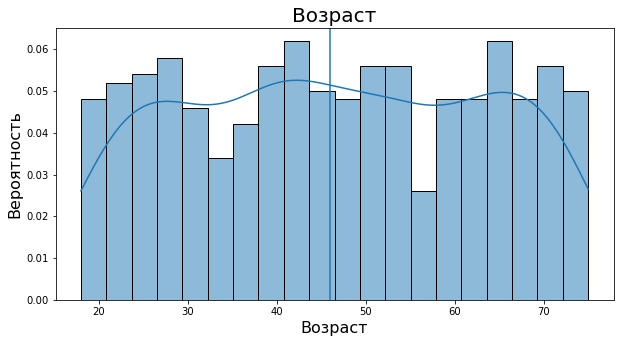

In [150]:
sns_hist(data_users['age'], 'Возраст', 'Возраст', bins = 20)

In [151]:
# data_users['tariff'].value_counts()
alt_value_counts(data_users, 'tariff', 'Количество пльзователей по тарифам')

alt.LayerChart(...)

Никаких заметных отклонений не обнаружили.

Проанализируем данные data_calls

In [152]:
print('Количество дубликатов - ',data_calls.duplicated().sum())

Количество дубликатов -  0


Дубликатов нет.

In [153]:
data_calls.head()

,id,call_date,duration,user_id
0,1000_0,2018-07-25,0.00,1000
1,1000_1,2018-08-17,0.00,1000
2,1000_2,2018-06-11,2.85,1000
3,1000_3,2018-09-21,13.80,1000
4,1000_4,2018-12-15,5.18,1000


Проверим все ли действительно даты приходятся на 2018-й год. Найдем минимальную и максимальную дату.

In [154]:
print('Минимальная дата равна {}'.format(data_calls['call_date'].min()))
print('Максимальная дата равна {}'.format(data_calls['call_date'].max()))

Минимальная дата равна 2018-01-01 00:00:00
Максимальная дата равна 2018-12-31 00:00:00


Вспоминаем, что оператор округляет количество минут вверх. Это значит, что нам необходимо округлить сразу же длительность в вверхнюю сторону. Сохраним это значение в отдельном столбце - duration_counted.

Также для дальнейшего анализа нам необходимо вычислить месяц. Все даты находятся в 2018-м - можем сразу вычислить месяц. Сохраним его в отдельной колонке. 

In [155]:
data_calls['duration_counted'] = data_calls['duration'].apply(np.ceil)
data_calls['month'] = data_calls['call_date'].dt.month

In [156]:
data_calls.describe()

,duration,user_id,duration_counted,month
count,202607.000000,202607.000000,202607.000000,202607.000000
mean,6.755887,1253.940619,7.158198,8.574067
std,5.843365,144.722751,5.959173,2.787093
min,0.000000,1000.000000,0.000000,1.000000
25%,1.300000,1126.000000,2.000000,7.000000
50%,6.000000,1260.000000,6.000000,9.000000
75%,10.700000,1379.000000,11.000000,11.000000
max,38.000000,1499.000000,38.000000,12.000000


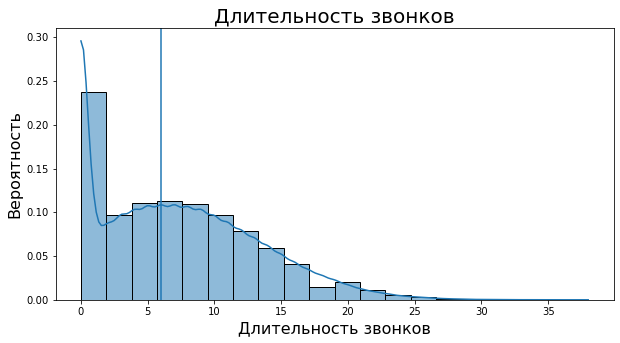

In [157]:
sns_hist(data_calls['duration_counted'], 'Длительность звонков', 'Длительность звонков', bins = 20)

In [158]:
#data_calls.hist('duration_counted', bins = 20)
#plt.title("Длительность звонков")
#plt.ylabel("Количество наблюдений, шт.")
#plt.xlabel("Длительность звонков");

In [159]:
#data_calls['duration_counted'].value_counts()

alt_value_counts(data_calls, 'duration_counted', 'Продолжительность звонков, мин.')

alt.LayerChart(...)

Замечаем огромное количество нулевых значений. Видимо это пропущенные вызовы и/или прозвоны. Количество таковых значений очень велико - 39613. Это около 19,5% от общей выборки.

У нас дилемма.. С одной стороны избавиться от них мы не можем (их число слишком велико), а с другой - они очевидно будут влиять на "полезные" данные. Оставим текущий датасет как есть. Но создадим новый - без учета звонков с нулевой длительностью - data_calls_active.

In [160]:
data_calls_active = data_calls.query('duration > 0 ')

Проанализируем теперь этот датасет и сравним результаты с первоначальным.

In [161]:
data_calls_active.describe()

,duration,user_id,duration_counted,month
count,162994.000000,162994.000000,162994.000000,162994.000000
mean,8.397794,1254.149877,8.897880,8.572960
std,5.353022,144.751050,5.353761,2.787315
min,0.010000,1000.000000,1.000000,1.000000
25%,4.170000,1126.000000,5.000000,7.000000
50%,7.740000,1261.000000,8.000000,9.000000
75%,11.850000,1379.000000,12.000000,11.000000
max,38.000000,1499.000000,38.000000,12.000000


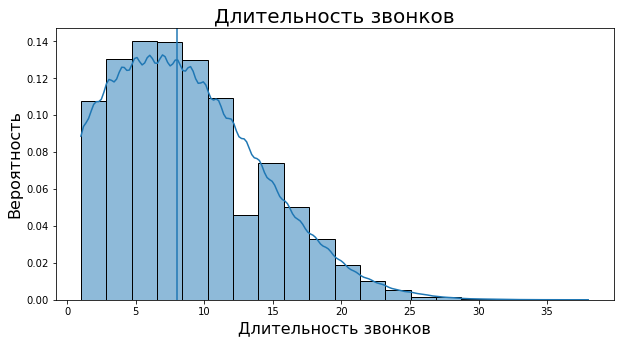

In [162]:
sns_hist(data_calls_active['duration_counted'], 'Длительность звонков', 'Длительность звонков', bins = 20)

Заметим, что теперь распределение длительности звонков стало похоже на нормальное. 
Средняя длительность выросла с 6.75 до 8.4, медиана - с 6 до 7.74, а среднеквадрати́чное отклонение уменьшилось с 5,84 до 5,35.

Проанализируем датасет data_internet. Аналогично количеству минут - количество потраченных Мб округляется вверх, поэтому добавим ещё один столбец mb_used_counted.

Также для дальнейшего анализа нам необходимо вычислить месяц. Все даты находятся в 2018-м - можем сразу вычислить месяц. Сохраним его в отдельной колонке. 

In [163]:
print('Минимальная дата равна {}'.format(data_internet['session_date'].min()))
print('Максимальная дата равна {}'.format(data_internet['session_date'].max()))

Минимальная дата равна 2018-01-01 00:00:00
Максимальная дата равна 2018-12-31 00:00:00


In [164]:
data_internet['mb_used_counted'] = data_internet['mb_used'].apply(np.ceil)
data_internet['month'] = data_internet['session_date'].dt.month

In [165]:
data_internet.head()

,id,mb_used,session_date,user_id,mb_used_counted,month
0,1000_0,112.95,2018-11-25,1000,113.0,11
1,1000_1,1052.81,2018-09-07,1000,1053.0,9
2,1000_2,1197.26,2018-06-25,1000,1198.0,6
3,1000_3,550.27,2018-08-22,1000,551.0,8
4,1000_4,302.56,2018-09-24,1000,303.0,9


In [166]:
data_internet.describe()

,mb_used,user_id,mb_used_counted,month
count,149396.000000,149396.000000,149396.000000,149396.000000
mean,370.192426,1252.099842,370.622098,8.563315
std,278.300951,144.050823,278.387019,2.788717
min,0.000000,1000.000000,0.000000,1.000000
25%,138.187500,1130.000000,139.000000,7.000000
50%,348.015000,1251.000000,349.000000,9.000000
75%,559.552500,1380.000000,560.000000,11.000000
max,1724.830000,1499.000000,1725.000000,12.000000


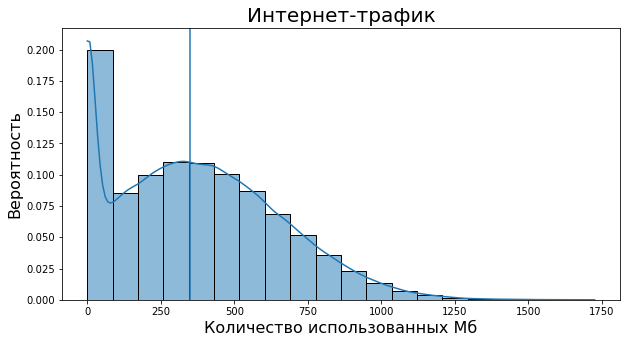

In [167]:
sns_hist(data_internet['mb_used_counted'], 'Интернет-трафик', 'Количество использованных Мб', bins = 20)

In [168]:
alt_value_counts(data_internet, 'mb_used_counted', 'Количество использованных Мб')
#data_internet['mb_used_counted'].value_counts()

alt.LayerChart(...)

Снова замечаем очень большое количество 19,6 тыс или более 11% нулевых значений потраченных Мб. Вероятно - это "фантомные" сессии, когда пользователь был в сети, но в интернет не заходил. 

Это очень много, чтобы от них избавиться - введем дополнительный датасет без учета этих значений - data_internet_active.

In [169]:
data_internet_active = data_internet.query('mb_used > 0')

In [170]:
data_internet_active.describe()

,mb_used,user_id,mb_used_counted,month
count,129798.000000,129798.000000,129798.000000,129798.000000
mean,426.087210,1253.046318,426.581758,8.558013
std,255.596447,143.782672,255.596114,2.787862
min,0.030000,1000.000000,1.000000,1.000000
25%,227.460000,1132.000000,228.000000,7.000000
50%,400.540000,1252.000000,401.000000,9.000000
75%,592.947500,1380.000000,593.000000,11.000000
max,1724.830000,1499.000000,1725.000000,12.000000


Посмотрим, как изменились наши основные статистические характеристики:

    Мат.ожидание с 370.2 увеличилось до 426
    Медиана увеичилась с 348 до 400,5
    Среднеквадратическое  отклонение уменьшилось с 278.3 до 255,6

Проанализируем табличку data_messages.

In [171]:
data_messages.head()

,id,message_date,user_id
0,1000_0,2018-06-27,1000
1,1000_1,2018-10-08,1000
2,1000_2,2018-08-04,1000
3,1000_3,2018-06-16,1000
4,1000_4,2018-12-05,1000


In [172]:
print('Минимальная дата равна {}'.format(data_messages['message_date'].min()))
print('Максимальная дата равна {}'.format(data_messages['message_date'].max()))

Минимальная дата равна 2018-01-02 00:00:00
Максимальная дата равна 2018-12-31 00:00:00


Также для дальнейшего анализа нам необходимо вычислить месяц. Все даты находятся в 2018-м - можем сразу вычислить месяц. Сохраним его в отдельной колонке.

In [173]:
data_messages['month'] = data_messages['message_date'].dt.month

Приступим к рассчетам. 
    
    Необходимо рассчитать для каждого пользователя количество сделанных звонков и израсходованных минут разговора по месяцам.
    
Очень интересно заодно проверить количество "активных" звонков (не включая пропущенные/прозвоны) 

In [174]:
User_calls_stat = data_calls.pivot_table(
    index = ['user_id', 'month'], 
    values = 'duration_counted', 
    aggfunc = ['count', 'sum']
)

In [175]:
User_activecalls_stat = data_calls_active.pivot_table(
    index = ['user_id', 'month'], 
    values = 'duration_counted', 
    aggfunc = ['count']
)

In [176]:
User_calls_stat.columns = ['Calls', 'Minutes']
User_activecalls_stat.columns = ['Active_calls']

In [177]:
User_calls_stat.reset_index(inplace=True)  
User_activecalls_stat.reset_index(inplace=True)  

In [178]:
User_calls_stat.head(10)

,user_id,month,Calls,Minutes
0,1000,5,22,159.0
1,1000,6,43,172.0
2,1000,7,47,340.0
3,1000,8,52,408.0
4,1000,9,58,466.0
5,1000,10,57,350.0
6,1000,11,43,338.0
7,1000,12,46,333.0
8,1001,11,59,430.0
9,1001,12,63,414.0


In [179]:
User_activecalls_stat.head(10)

,user_id,month,Active_calls
0,1000,5,17
1,1000,6,28
2,1000,7,41
3,1000,8,42
4,1000,9,46
5,1000,10,44
6,1000,11,37
7,1000,12,38
8,1001,11,45
9,1001,12,47


Продолжим рассчеты. Найдем количество отправленных сообщений для каждого пользователя по месяцам.

In [180]:
User_messages_stat = data_messages.pivot_table(index = ['user_id', 'month'], values = 'message_date', aggfunc = ['count'])

In [181]:
User_messages_stat.columns = ['messages']
User_messages_stat.reset_index(inplace = True)

In [182]:
User_messages_stat.head()

,user_id,month,messages
0,1000,5,22
1,1000,6,60
2,1000,7,75
3,1000,8,81
4,1000,9,57


Найдем объем израсходованного интернет-трафика для каждого пользователя по месяцам.

In [183]:
User_internet_stat = data_internet.pivot_table(
    index = ['user_id', 'month'], 
    values = 'mb_used_counted', 
    aggfunc = ['sum']
)

In [184]:
User_internet_stat.columns = ['traffic']
User_internet_stat.reset_index(inplace = True)

In [185]:
User_internet_stat.head()

,user_id,month,traffic
0,1000,5,2256.0
1,1000,6,23257.0
2,1000,7,14016.0
3,1000,8,14070.0
4,1000,9,14581.0


Сведем полученные данные в одну табличку - User_stat.

In [186]:
User_stat = User_calls_stat.set_index(['user_id', 'month']).join(
    User_activecalls_stat.set_index(['user_id', 'month']), how = 'outer')

User_stat = User_stat.join(User_messages_stat.set_index(['user_id', 'month']), how = 'outer')

User_stat = User_stat.join(User_internet_stat.set_index(['user_id', 'month']), how = 'outer')

In [187]:
User_internet_stat['traffic'].sum(), User_stat['traffic'].sum()

(55369459.0, 55369459.0)

In [188]:
User_stat.head()

Calls  Minutes  Active_calls  messages  traffic
user_id month                                                 
1000    5       22.0    159.0          17.0      22.0   2256.0
        6       43.0    172.0          28.0      60.0  23257.0
        7       47.0    340.0          41.0      75.0  14016.0
        8       52.0    408.0          42.0      81.0  14070.0
        9       58.0    466.0          46.0      57.0  14581.0

Проверим полученный датасет на пропущенные значения.

In [189]:
User_stat.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 3214 entries, (1000, 5) to (1499, 12)
Data columns (total 5 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Calls         3174 non-null   float64
 1   Minutes       3174 non-null   float64
 2   Active_calls  3168 non-null   float64
 3   messages      2717 non-null   float64
 4   traffic       3203 non-null   float64
dtypes: float64(5)
memory usage: 159.4 KB


Количество звонков и количество минут - без пропущенных значений. В остальных колонках - пропущенные значения есть. Очевидно, что пропущенные значения не посчитались из-за отсутствия данных, поэтому логично их заполнить нулями.

In [190]:
User_stat = User_stat.fillna(0)

Рассчитаем по каждому пользователю помесячную выручку. Для этого добавим в текущий датасет колонку 'tariff' в зависимости от пользователя. Предварительно сбросим индекс.

In [191]:
User_stat.reset_index(inplace = True)

Создадим отдельную табличку соответствий пользователь - тариф, чтобы не тащить все колонки в таблицу user_stat

In [192]:
data_users2tariff = data_users[['user_id', 'tariff']]

In [193]:
User_stat = User_stat.set_index('user_id').join(data_users2tariff.set_index('user_id'))

Проверяем

In [194]:
User_stat.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3214 entries, 1000 to 1499
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   month         3214 non-null   int64  
 1   Calls         3214 non-null   float64
 2   Minutes       3214 non-null   float64
 3   Active_calls  3214 non-null   float64
 4   messages      3214 non-null   float64
 5   traffic       3214 non-null   float64
 6   tariff        3214 non-null   object 
dtypes: float64(5), int64(1), object(1)
memory usage: 200.9+ KB


In [195]:
User_stat.reset_index(inplace = True)
User_stat.head()

,user_id,month,Calls,Minutes,Active_calls,messages,traffic,tariff
0,1000,5,22.0,159.0,17.0,22.0,2256.0,ultra
1,1000,6,43.0,172.0,28.0,60.0,23257.0,ultra
2,1000,7,47.0,340.0,41.0,75.0,14016.0,ultra
3,1000,8,52.0,408.0,42.0,81.0,14070.0,ultra
4,1000,9,58.0,466.0,46.0,57.0,14581.0,ultra


Отлично! Теперь мы готовы к рассчёту помесячной выручки. Напишем специальные функции для рассчета выручки по звонкам/сообщениям/интернету. Добавим соответствующие колонки и, потом, суммарную.

Напишем функцию, которая будут выводить лимиты по сообщения/минутам/траффику, а также соответствующие стоимости сверх лимита и абонентскую плату по введенному параметру и названию тарифа.

In [196]:
def get_param(tariff, param):
    """
    tariff: наименование тарифа
    param: наименование колонки датасета data_tariffs
    """
    return data_tariffs.query('tariff == @tariff')[param].reset_index(drop = True)[0]

Проверим нашу функцию

In [197]:
print(get_param('ultra', 'minutes_included'))
print(get_param('smart', 'rub_per_message'))

3000
3


Функция для рассчета дохода по минутам сверх траффика.

In [198]:
def calc_calls_income(row):
    try:
        minutes = row['Minutes']
        limit = get_param(row['tariff'], 'minutes_included')
        cost = get_param(row['tariff'], 'rub_per_minute')
        over_the_limit = minutes - limit
        if over_the_limit <= 0:
            return 0
        return cost * over_the_limit
    except:
        return 'Ошибка при вычислении'

Функция для рассчета дохода по сообщениям сверх траффика.

In [199]:
def calc_messages_income(row):
    try:
        messages = row['messages']
        limit = get_param(row['tariff'], 'messages_included')
        cost = get_param(row['tariff'], 'rub_per_message')
        over_the_limit = messages - limit
        if over_the_limit <= 0:
            return 0
        return cost * over_the_limit
    except:
        return 'Ошибка при вычислении'

Функция для рассчета дохода по потраченным Мб сверх траффика. Т.к. сверх лимита идёт рассчёт уже в Гб - будем переводить трафик сверх лимита в Гб (делить разность на 1024) и округлять вверх.  

In [200]:
def calc_traffic_income(row):
    try:
        traffic = row['traffic']
        limit = get_param(row['tariff'], 'mb_per_month_included')
        cost = get_param(row['tariff'], 'rub_per_gb')
        over_the_limit = np.ceil((traffic - limit) / 1024)
        if over_the_limit <= 0:
            return 0
        return cost * over_the_limit
    except:
        return 'Ошибка при вычислении'

Рассчитаем теперь доходы по звонкам/сообщениям/интернету..

In [201]:
User_stat['Calls_Income'] = User_stat.apply(calc_calls_income, axis = 1)

In [202]:
User_stat['Messages_Income'] = User_stat.apply(calc_messages_income, axis = 1)

In [203]:
User_stat['Internet_Income'] = User_stat.apply(calc_traffic_income, axis = 1)

Проверим что получилось.

In [204]:
User_stat.tail()

,user_id,month,Calls,Minutes,Active_calls,messages,traffic,tariff,Calls_Income,Messages_Income,Internet_Income
3209,1498,10,41.0,247.0,30.0,42.0,20604.0,smart,0.0,0.0,1200.0
3210,1499,9,9.0,70.0,8.0,11.0,1848.0,smart,0.0,0.0,0.0
3211,1499,10,68.0,449.0,44.0,48.0,17809.0,smart,0.0,0.0,600.0
3212,1499,11,74.0,612.0,62.0,59.0,17984.0,smart,336.0,27.0,600.0
3213,1499,12,69.0,492.0,56.0,66.0,13077.0,smart,0.0,48.0,0.0


Для рассчёта помесячной выручки осталось добавить в таблицу абонентскую плату.
Вынесем в отдельную таблицу соответствие тариф-абонентская плата, чтобы не тащить все колонки в исходную таблицу. 

In [205]:
tariff_2_fee = data_tariffs[['tariff', 'rub_monthly_fee']]

In [206]:
User_stat = User_stat.set_index('tariff').join(tariff_2_fee.set_index('tariff'))


In [207]:
User_stat.reset_index(inplace = True)
User_stat.tail()

,tariff,user_id,month,Calls,Minutes,Active_calls,messages,traffic,Calls_Income,Messages_Income,Internet_Income,rub_monthly_fee
3209,ultra,1495,8,17.0,92.0,13.0,13.0,2616.0,0.0,0.0,0.0,1950
3210,ultra,1495,9,112.0,813.0,95.0,82.0,33105.0,0.0,0.0,450.0,1950
3211,ultra,1495,10,152.0,1030.0,126.0,82.0,29393.0,0.0,0.0,0.0,1950
3212,ultra,1495,11,129.0,954.0,112.0,79.0,38972.0,0.0,0.0,1350.0,1950
3213,ultra,1495,12,155.0,1031.0,120.0,84.0,23450.0,0.0,0.0,0.0,1950


Теперь можем посчитать итоговую помесячную выручку с каждого пользователя.

In [208]:
User_stat['Total_Income'] = (User_stat['Calls_Income'] 
            + User_stat['Messages_Income'] 
            + User_stat['Internet_Income'] 
            + User_stat['rub_monthly_fee'])

Проверим, что получилось

In [209]:
User_stat.head(10)

,tariff,user_id,month,Calls,Minutes,Active_calls,messages,traffic,Calls_Income,Messages_Income,Internet_Income,rub_monthly_fee,Total_Income
0,smart,1001,11,59.0,430.0,45.0,0.0,18452.0,0.0,0.0,800.0,550,1350.0
1,smart,1001,12,63.0,414.0,47.0,0.0,14053.0,0.0,0.0,0.0,550,550.0
2,smart,1002,6,15.0,117.0,14.0,4.0,10871.0,0.0,0.0,0.0,550,550.0
3,smart,1002,7,26.0,214.0,21.0,11.0,17601.0,0.0,0.0,600.0,550,1150.0
4,smart,1002,8,42.0,289.0,37.0,13.0,20347.0,0.0,0.0,1000.0,550,1550.0
5,smart,1002,9,36.0,206.0,25.0,4.0,16712.0,0.0,0.0,400.0,550,950.0
6,smart,1002,10,33.0,212.0,24.0,10.0,13905.0,0.0,0.0,0.0,550,550.0
7,smart,1002,11,32.0,243.0,25.0,16.0,18610.0,0.0,0.0,800.0,550,1350.0
8,smart,1002,12,33.0,236.0,27.0,12.0,18137.0,0.0,0.0,600.0,550,1150.0
9,smart,1005,1,15.0,95.0,11.0,7.0,2730.0,0.0,0.0,0.0,550,550.0


### Вывод

На этом этапе мы решили проблемы выявленные на первом этапе. Необходимые колонки были приведены к типу DateTime. Ненужные колонки - удалены.

Провели анализ данных. Выявили очень большое количество нулевых значений в таблицах data_calls и data_internet.

data_calls:

Огромное количество нулевых значений. Видимо это пропущенные вызовы и/или прозвоны. Количество таковых значений очень велико - 39613. Это около 19,5% от общей выборки. Дилемма.. С одной стороны избавиться от них мы не можем (их число слишком велико), а с другой - они очевидно будут влиять на "полезные" данные. Оставим текущий датасет как есть. Но создадим новый - без учета звонков с нулевой длительностью - data_calls_active.
Оценили статистические характеристики data_calls_active в сравнении с data_calls.
Распределение длительности звонков стало похоже на нормальное. Средняя длительность выросла с 6.75 до 8.4, медиана - с 6 до 7.74, а среднеквадрати́чное отклонение уменьшилось с 5,84 до 5,35.


data_internet:
Очень большое количество 19,6 тыс или более 11% нулевых значений потраченных Мб. Вероятно - это "фантомные" сессии, когда пользователь был в сети, но в интернет не заходил. Создали новую табличку data_internet_active, в которую не вошли нулевые значения.
Вот так изменились наши основные статистические характеристики:
Мат.ожидание с 370.2 увеличилось до 426
Медиана увеичилась с 348 до 400,5
Среднеквадратическое  отклонение уменьшилось с 278.3 до 255,6

После чего посчитали для каждого пользователя статистику по месяцам.

    количество сделанных звонков и израсходованных минут разговора по месяцам;
    количество отправленных сообщений по месяцам;
    объем израсходованного интернет-трафика по месяцам;
    помесячную выручку с каждого пользователя.

<a name="paragraph3"></a>
## 3. Анализ данных

Приступим к анализу данных.


In [210]:
User_stat_smart = User_stat.query('tariff == "smart"')

In [211]:
User_stat_ultra = User_stat.query('tariff == "ultra"')

Проанализируем общие статистические характеристики для обоих тарифов.

Тариф - smart

In [212]:
User_stat_smart.describe()

,user_id,month,Calls,Minutes,Active_calls,messages,traffic,Calls_Income,Messages_Income,Internet_Income,rub_monthly_fee,Total_Income
count,2229.000000,2229.000000,2229.000000,2229.000000,2229.000000,2229.000000,2229.000000,2229.000000,2229.000000,2229.000000,2229.0,2229.000000
mean,1246.506505,8.346792,58.463437,417.934948,46.947510,33.384029,16229.188425,124.816958,17.399731,602.422611,550.0,1294.639300
std,146.119496,2.920316,25.939858,190.313730,21.039171,28.227876,5877.576978,254.035718,40.327368,739.433926,0.0,820.933202
min,1001.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,550.0,550.000000
25%,1121.000000,6.000000,40.000000,282.000000,32.000000,10.000000,12658.000000,0.000000,0.000000,0.000000,550.0,550.000000
50%,1239.000000,9.000000,60.000000,422.000000,47.000000,28.000000,16531.000000,0.000000,0.000000,400.000000,550.0,1038.000000
75%,1376.000000,11.000000,76.000000,545.000000,61.000000,51.000000,20068.000000,135.000000,3.000000,1000.000000,550.0,1750.000000
max,1499.000000,12.000000,198.000000,1435.000000,162.000000,143.000000,38610.000000,2805.000000,279.000000,4600.000000,550.0,6770.000000


Тариф - ultra

In [213]:
User_stat_ultra.describe()

,user_id,month,Calls,Minutes,Active_calls,messages,traffic,Calls_Income,Messages_Income,Internet_Income,rub_monthly_fee,Total_Income
count,985.000000,985.000000,985.000000,985.000000,985.000000,985.000000,985.000000,985.0,985.0,985.000000,985.0,985.000000
mean,1263.094416,8.250761,73.392893,526.623350,59.236548,49.363452,19486.901523,0.0,0.0,121.065990,1950.0,2071.065990
std,140.694908,2.871762,43.916853,317.606098,35.562722,47.804457,10096.317202,0.0,0.0,378.802377,0.0,378.802377
min,1000.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000,1950.0,1950.000000
25%,1143.000000,6.000000,41.000000,284.000000,33.000000,6.000000,11785.000000,0.0,0.0,0.000000,1950.0,1950.000000
50%,1277.000000,9.000000,74.000000,518.000000,58.000000,38.000000,19324.000000,0.0,0.0,0.000000,1950.0,1950.000000
75%,1381.000000,11.000000,104.000000,752.000000,84.000000,79.000000,26863.000000,0.0,0.0,0.000000,1950.0,1950.000000
max,1495.000000,12.000000,244.000000,1673.000000,190.000000,224.000000,49789.000000,0.0,0.0,2850.000000,1950.0,4800.000000


Проанализируем общее количество потраченных минут в месяц по обоим тарифам.

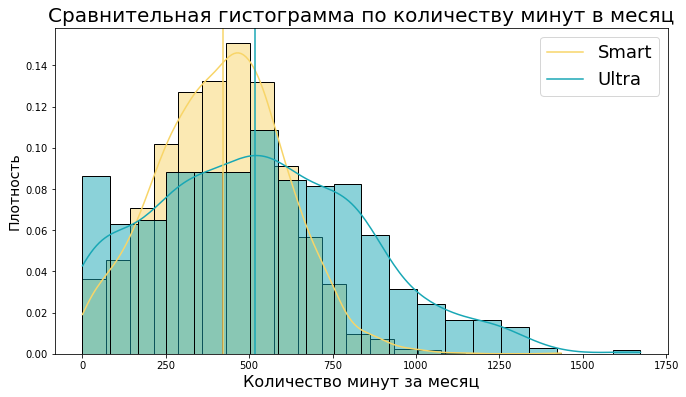

In [214]:
side_by_side_hist(
    User_stat_smart['Minutes'],
    User_stat_ultra['Minutes'],
    'Сравнительная гистограмма по количеству минут в месяц', 
    'Количество минут за месяц', 
    ['Smart', 'Ultra']
)

Посчитаем дисперсии

In [215]:
print('Тариф Smart. Общее количество потраченных минут. Дисперсия: {}'.
      format(np.var(User_stat_smart['Minutes'])))
print('Тариф Ultra. Общее количество потраченных минут. Дисперсия: {}'.
      format(np.var(User_stat_ultra['Minutes'])))


Тариф Smart. Общее количество потраченных минут. Дисперсия: 36203.066652094654
Тариф Ultra. Общее количество потраченных минут. Дисперсия: 100771.22361720214


##### Количество минут - вывод:

    Проанализировали общее количество потраченных минут, а также добавили дополнительную прибыль при выходе из лимита.
    
    Тариф smart (по плану - 500)
        Среднее количество минут - 417.9
        Среднеквадратическое отклонение - 190.3
        Медиана - 422
        Средняя прибыль по минутам сверх лимита - 124.8
        Дисперсия - 36203
        
    Тариф ultra (по плану - 3000)
        Среднее количество минут - 526.6
        Среднеквадратическое отклонение - 317.6
        Медиана - 518
        Средняя прибыль по минутам сверх лимита - 0
        Дисперсия - 100771
        
Заметим, что количество потраченных минут для пользователей обоих тарифов отличается, но не очень сильно. Пик на графике и среднее/медиана для тарифа smart находится до 500 (в районе 420), а для пользователей ultra чуть выше 500 - 520-550, но эти значения для пользователей преподнесли бы дополнительные затраты, если бы они были на тарифе smart. При этом распределение для пользователей тарифа ultra относительно равномерное. Примерно, на интервале 250-800 - значения распределены равномерно, за исключением небольшого пика около 550. 


При этом, если пользователи тарифа smart доплачивают порой сверх абонентской за минуты сверх лимита, то пользователи тарифа ultra не только к этому не близки, но у них ещё и огромный запас. При лимите минут в 3000 - максимальное потраченное за месяц значение минут - 1673. Это значит, что дополнительную прибыль по звонкам пользователи тарифа ultra не принесут.

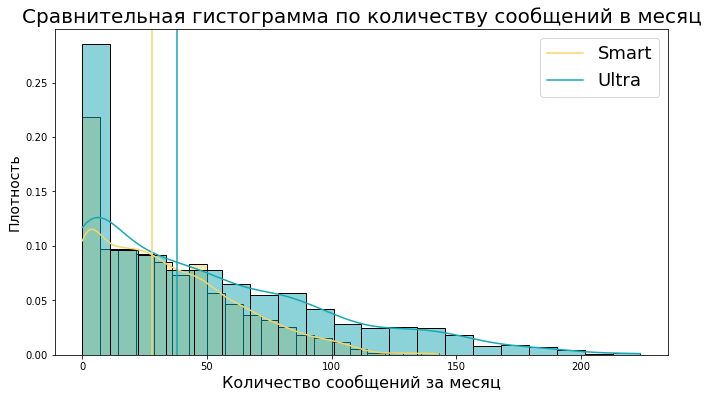

In [216]:
side_by_side_hist(
    User_stat_smart['messages'],
    User_stat_ultra['messages'],
    'Сравнительная гистограмма по количеству сообщений в месяц', 
    'Количество сообщений за месяц', 
    ['Smart', 'Ultra']
)

 Посчитаем дисперсии

In [217]:
print('Тариф Smart. Общее количество сообщений. Дисперсия: {}'.
      format(np.var(User_stat_smart['messages'])))
print('Тариф Ultra. Общее количество сообщений. Дисперсия: {}'.
      format(np.var(User_stat_ultra['messages'])))


Тариф Smart. Общее количество сообщений. Дисперсия: 796.455482917076
Тариф Ultra. Общее количество сообщений. Дисперсия: 2282.946075394892


##### Количество сообщений - вывод:

Проанализировали общее количество сообщений в месяц, а также проанализировали дополнительную прибыль по этому параметру.
    
    Тариф smart (по плану - 50)
        Среднее количество сообщений - 33.4
        Среднеквадратическое отклонение - 28.3
        Медиана - 28
        Средняя прибыль - 17.5
        Дисперсия - 796
    Тариф ultra (по плану - 1000)
        Среднее количество сообщений - 49.4
        Среднеквадратическое отклонение - 47.8
        Медиана - 38
        Средняя прибыль - 0
        Дисперсия - 2283
        
Аналогичная ситуация и сообщениями. Пользователи ultra отправляют их не сильно больше и очень далеки от лимита, чтобы приносить дополнительную прибыль. При этом пользователи тарифа smart хоть и немного (самую малость), но выходят за рамки лимита и приносят дополнительную прибыль по этому параметру. 

При этом по графику становится очевидно, что пик приходится на значения до и около 10 (для обоих тарифов), после чего значения идут на убыль. Видимо, сообщения уходят в прошлое и нет никаких предпосылок для смещения этого пика в большую сторону.

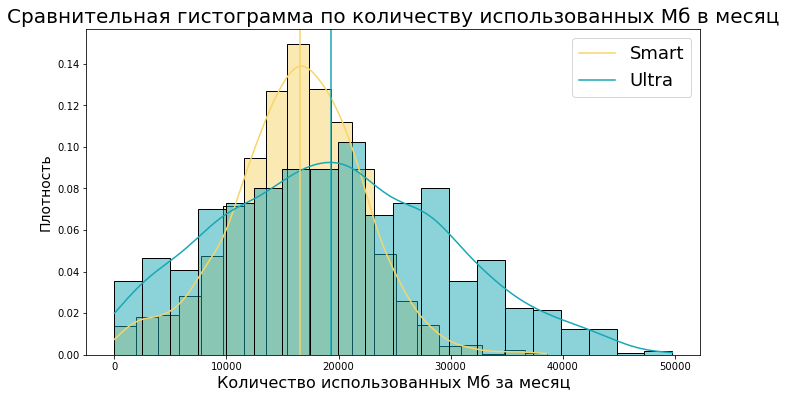

In [218]:
side_by_side_hist(
    User_stat_smart['traffic'],
    User_stat_ultra['traffic'],
    'Сравнительная гистограмма по количеству использованных Мб в месяц', 
    'Количество использованных Мб за месяц', 
    ['Smart', 'Ultra']
)

Посчитаем дисперсии

In [219]:
print('Тариф Smart. Общее количество сообщений. Дисперсия: {}'.
      format(np.var(User_stat_smart['traffic'])))
print('Тариф Ultra. Общее количество сообщений. Дисперсия: {}'.
      format(np.var(User_stat_ultra['traffic'])))


Тариф Smart. Общее количество сообщений. Дисперсия: 34530412.737039655
Тариф Ultra. Общее количество сообщений. Дисперсия: 101832133.10806865


##### Количество потраченных Мб - вывод:

Проанализировали общее количество потраченных Мб в месяц, а также проанализировали дополнительную прибыль по этому параметру.
    
    Тариф smart (по плану - 15360)
        Среднее количество потраченных Мб - 16229
        Среднеквадратическое отклонение - 5877
        Медиана - 16531
        Средняя прибыль - 602
        Дисперсия - 34530413
        
    Тариф ultra (по плану - 1000)
        Среднее количество потраченных Мб - 19486
        Среднеквадратическое отклонение - 10096
        Медиана - 19324
        Средняя прибыль - 121
        Дисперсия - 101832133
        
Итак, пользователи обоих тарифов также не очень сильно отличаются по потреблению интернета. Однако распределения разные.. У тарифа smart прослеживается более яркий пик на гистограмме, в районе значений 15000-17500. Для тарифа ultra значения относительно равномерно "размазаны" на интервале 7500-30000, что подтверждается также среднеквадратическим отклонением - для ultra оно гораздо больше.

При этом, если пользователи ultra выходят за рамки лимита крайне редко, то пользователи тарифа смарт выходят из лимита регулярно - среднее и медиана лежат выше лимита.
При этом дополнительную прибыль относительно абонентсткой платы дают оба тарифа. smart даёт побольше (602), ultra - чуть поменьше (121).

### Вывод:

Мы провели анализ основных характеристик тарифных планов smart и ultra - сколько минут, сообщений, интернет-траффика необходимо пользователям каждого тарифа в месяц.

Количество минут - вывод:

Тариф smart (по плану - 500)
    Среднее количество минут - 419.1
    Среднеквадратическое отклонение - 189.3
    Медиана - 423
    Средняя прибыль по минутам сверх лимита - 125.2

Тариф ultra (по плану - 3000)
    Среднее количество минут - 545.5
    Среднеквадратическое отклонение - 306.9
    Медиана - 528
    Средняя прибыль по минутам сверх лимита - 0

Заметим, что количество потраченных минут для пользователей обоих тарифов отличается, но не очень сильно. Пик на графике и среднее/медиана для тарифа smart находится до 500 (в районе 420), а для пользователей ultra чуть выше 500 - 520-550, но эти значения для пользователей преподнесли бы дополнительные затраты, если бы они были на тарифе smart. При этом распределение для пользователей тарифа ultra относительно равномерное. Примерно, на интервале 250-800 - значения распределены равномерно, за исключением небольшого пика около 550.

При этом, если пользователи тарифа smart доплачивают порой сверх абонентской за минуты сверх лимита, то пользователи тарифа ultra не только к этому не близки, но у них ещё и огромный запас. При лимите минут в 3000 - максимальное потраченное за месяц значение минут - 1673. Это значит, что дополнительную прибыль по звонкам пользователи тарифа ultra не принесут.

Количество сообщений - вывод:

Тариф smart (по плану - 50)
    Среднее количество сообщений - 33.4
    Среднеквадратическое отклонение - 28.3
    Медиана - 28
    Средняя прибыль - 17.5

Тариф ultra (по плану - 1000)
    Среднее количество сообщений - 49
    Среднеквадратическое отклонение - 46.9
    Медиана - 39
    Средняя прибыль - 0

Аналогичная ситуация и сообщениями. Пользователи ultra отправляют их не сильно больше и очень далеки от лимита, чтобы приносить дополнительную прибыль. При этом пользователи тарифа smart хоть и немного (самую малость), но выходят за рамки лимита и приносят дополнительную прибыль по этому параметру.

При этом по графику становится очевидно, что пик приходится на значения до и около 10 (для обоих тарифов), после чего значения идут на убыль. Видимо, сообщения уходят в прошлое и нет никаких предпосылок для смещения этого пика в большую сторону.

Объем интернет-трафика - вывод:

Тариф smart (по плану - 15360)
    Среднее количество потраченных Мб - 16230
    Среднеквадратическое отклонение - 5883
    Медиана - 16527
    Средняя прибыль - 603

Тариф ultra (по плану - 1000)
    Среднее количество потраченных Мб - 19480
    Среднеквадратическое отклонение - 10135
    Медиана - 19374
    Средняя прибыль - 122

Итак, пользователи обоих тарифов также не очень сильно отличаются по потреблению интернета. Однако распределения разные.. У тарифа smart прослеживается более яркий пик на гистограмме, в районе значений 15000-17500. Для тарифа ultra значения относительно равномерно "размазаны" на интервале 7500-30000, что подтверждается также среднеквадратическим отклонением - для ultra оно гораздо больше.

При этом, если пользователи ultra выходят за рамки лимита крайне редко, то пользователи тарифа смарт выходят из лимита регулярно - среднее и медиана лежат выше лимита. При этом дополнительную прибыль относительно абонентсткой платы дают оба тарифа. smart даёт побольше (603), ultra - чуть поменьше (122).


Кроме этого заметим, что общее количество месяцев (из выборки) проведенное на тарифе смарт равно 2223, а на тарифе ultra - 951. На основании чего делаем вывод, что тарифный план smart популярнее в 2.34 раза. Также мы высчитали сколько в среднем обходится пользователям данные тарифные планы: smart - 1296 и ultra - 2072. ultra обходится примерно в 1.6 раза дороже. Но именно за счёт популярности smart приносит доходов больше, а именно в 1,46 раза (2223x1296 / 951x2072).   


Анализируя необходимое количество минут/сообщений/объема интернет-траффика - можно сделать вывод, что в среднем пользователи обоих тарифных планов схожи друг с другом. Пользователи ultra потребляют, конечно, больше, но не в разы (как относятся лимиты обоих тарифных планов). Количество минут, если мы рассматриваем среднее/медиану (а они отличаются не сильно) ~420 и ~545. Про количество сообщений можно сказать, что не играют большую роль - можно было бы ими даже пренеберечь. Большинство пользователей ограничивается до 10 сообщениями в месяц, что с запасом меньше лимита на обоих тарифах. И объем потраченнного интернет-траффика - 16230 (smart) и 19480 (ultra). Количество потраченных минут (в среднем) для пользоватлей ultra больше в 1.3 раза, а интернет-траффика - в 1.2 раза. 

Если мы рассмотрим среднестатистические параметры пользователя пакета ultra на тарифном пане smart в плане оплаты. Получим следующие цифры 550 + 45х3 + 4х200 = 1485. И это запас ещё почти в 500р, или +2Гб и около 30 мин до стоимости тарифного плана ultra. В связи с этим - можно обосновать поведение пользователей: пользователи тарифного плана ultra любят перестраховываться и иметь запас, или, возможно, не хотят следить за лимитами. А пользователи, тарифного плана smart, наоборот, более расчетливы и готовы превышать лимиты в разумных пределах.


<a name="paragraph4"></a>
## 4. Проверка гипотез

##### Гипотеза №1. Средняя выручка пользователей тарифов «Ультра» и «Смарт» различается.

H0 - Средние выручки пользователей тарифов smart и ultra примерно равны

H1 - Средние выручки пользователей тарифов smart и ultra отличаются.

Зададим пороговое значение alpha = 0.05

In [220]:
alpha = 0.05

Посчитаем дисперсии

In [221]:
print('Тариф Smart. Общий доход. Дисперсия: {}'.
      format(np.var(User_stat_smart['Total_Income'])))
print('Тариф Ultra. Общий доход. Дисперсия: {}'.
      format(np.var(User_stat_ultra['Total_Income'])))


Тариф Smart. Общий доход. Дисперсия: 673628.9744267926
Тариф Ultra. Общий доход. Дисперсия: 143345.5641732557


Дисперсии отличаются в несколько раз. Лучше использовать параметр equal_var = False. Проверим, дополнительно, на тестах Левене и Барлетта.

In [222]:
stat_lv, p_lv = levene(User_stat_smart['Total_Income'], User_stat_ultra['Total_Income'])
stat_bt, p_bt = bartlett(User_stat_smart['Total_Income'], User_stat_ultra['Total_Income'])

print('p-value по тесту Левене {}'.format(p_lv))
print('p-value по тесту Барлетта {}'.format(p_bt))

p-value по тесту Левене 1.6855369377883898e-124
p-value по тесту Барлетта 3.002696850995861e-140


Очень маленькие p-value подтверждают большое расхождение в дисперсиях выборок

In [223]:
results = st.ttest_ind(
    User_stat_smart['Total_Income'],
    User_stat_ultra['Total_Income'], equal_var = False)

In [224]:
print('p-значение:', results.pvalue)

if (results.pvalue < alpha):
    print("Отвергаем нулевую гипотезу")
else:
    print("У нас не достаточно данных, чтобы отвергнуть нулевую гипотезу") 

p-значение: 2.7240946993530856e-246
Отвергаем нулевую гипотезу


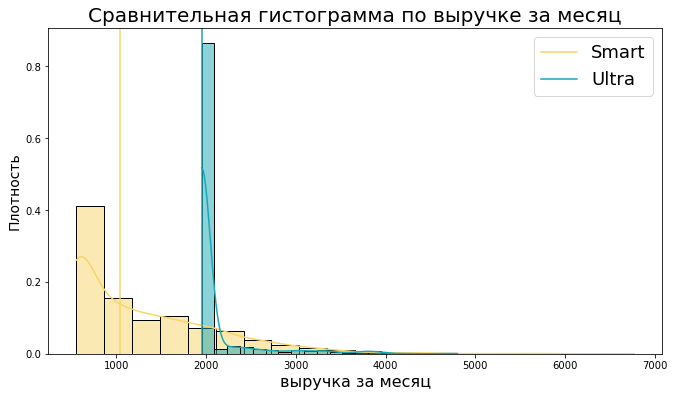

In [225]:
side_by_side_hist(
    User_stat_smart['Total_Income'],
    User_stat_ultra['Total_Income'],
    'Сравнительная гистограмма по выручке за месяц', 
    'выручка за месяц', 
    ['Smart', 'Ultra']
)

Значение p-value имеет порядок 10 в -246 степени. Что очень мало - из чего следует, что выручки пользователей тарифов smart и ultra имеют серьезные отличия. Что, в принципе, подтвержается посчитанными ранее значениями мат.ожидания и стандартного отклонения и построенным выше гистограммой - выручка за месяц пользователей тарифов smart и ultra. 

##### Гипотеза №2. Средняя выручка пользователей из Москвы отличается от выручки пользователей из других регионов. 
Добавим в датасет User_stat колонку город проживания пользователя - city. Для этого определим датасет соотношений пользователь - город.

In [226]:
User2City = data_users[['user_id', 'city']]

In [227]:
User2City.head()

,user_id,city
0,1000,Краснодар
1,1001,Москва
2,1002,Стерлитамак
3,1003,Москва
4,1004,Новокузнецк


In [228]:
User_stat = User_stat.set_index('user_id').join(User2City.set_index('user_id'))

In [229]:
User_stat.reset_index(inplace = True)

In [230]:
User_stat.head()

,user_id,tariff,month,Calls,Minutes,Active_calls,messages,traffic,Calls_Income,Messages_Income,Internet_Income,rub_monthly_fee,Total_Income,city
0,1000,ultra,5,22.0,159.0,17.0,22.0,2256.0,0.0,0.0,0.0,1950,1950.0,Краснодар
1,1000,ultra,6,43.0,172.0,28.0,60.0,23257.0,0.0,0.0,0.0,1950,1950.0,Краснодар
2,1000,ultra,7,47.0,340.0,41.0,75.0,14016.0,0.0,0.0,0.0,1950,1950.0,Краснодар
3,1000,ultra,8,52.0,408.0,42.0,81.0,14070.0,0.0,0.0,0.0,1950,1950.0,Краснодар
4,1000,ultra,9,58.0,466.0,46.0,57.0,14581.0,0.0,0.0,0.0,1950,1950.0,Краснодар


Выделим из полученной таблицы два датасета - данные Москвы и регионов.

In [231]:
User_stat_msk = User_stat.query('city == "Москва"')
User_stat_reg = User_stat.query('city != "Москва"')

Формулируем гипотезу:

H0 - Средние выручки пользователей тарифов из Москвы и регионов примерно равны

H1 - Средние выручки пользователей тарифов из Москвы и регионов отличаются.

Задаем пороговое значение alpha = 0.05:

In [232]:
alpha = 0.05

Посчитаем дисперсии

In [233]:
print('Пользователи из Москвы. Общий доход. Дисперсия: {}'.
      format(np.var(User_stat_msk['Total_Income'])))
print('Пользователи из регионов. Общий доход. Дисперсия: {}'.
      format(np.var(User_stat_reg['Total_Income'])))


Пользователи из Москвы. Общий доход. Дисперсия: 565256.3794161082
Пользователи из регионов. Общий доход. Дисперсия: 656514.2841040745


Дисперсии практически не отличаются. Лучше использовать параметр equal_var = True. Проверим, дополнительно, на тестах Левене и Барлетта.

In [234]:
stat_lv, p_lv = levene(User_stat_msk['Total_Income'], User_stat_reg['Total_Income'])
stat_bt, p_bt = bartlett(User_stat_msk['Total_Income'], User_stat_reg['Total_Income'])

print('p-value по тесту Левене {}'.format(p_lv))
print('p-value по тесту Барлетта {}'.format(p_bt))

p-value по тесту Левене 0.009373921759468934
p-value по тесту Барлетта 0.021658266854862596


Полученные p-value имеют достаточно высокие значения - дисперсии имеют примерно равные значения

In [235]:
result_msk2reg = st.ttest_ind(
    User_stat_msk['Total_Income'],
    User_stat_reg['Total_Income'], equal_var = True)

In [236]:
print('p-значение:', result_msk2reg.pvalue)

if (result_msk2reg.pvalue < alpha):
    print("Отвергаем нулевую гипотезу")
else:
    print("У нас не достаточно данных, чтобы отвергнуть нулевую гипотезу")

p-значение: 0.531666503831252
У нас не достаточно данных, чтобы отвергнуть нулевую гипотезу


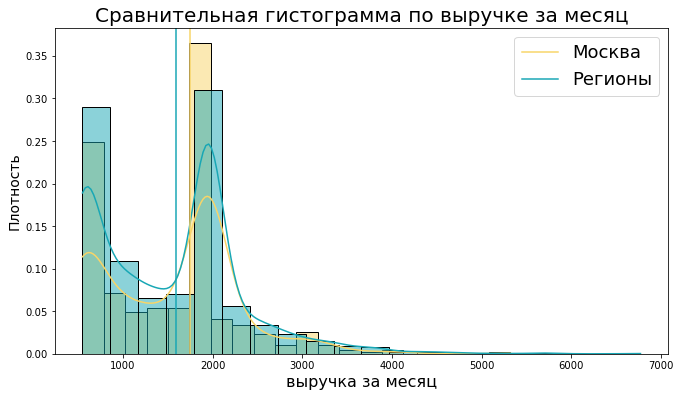

In [237]:
side_by_side_hist(
    User_stat_msk['Total_Income'],
    User_stat_reg['Total_Income'],
    'Сравнительная гистограмма по выручке за месяц', 
    'выручка за месяц', 
    ['Москва', 'Регионы']
)

Значение p-value равно 0.53. Что достаточно много и говорит о том, что выручки пользователей из Москвы и регионов в целом схожи. Что, в принципе, подтвержается посчитанными ранее значениями мат.ожидания и стандартного отклонения и построенным выше гистограммой - выручка за месяц пользователей из Москвы и регионов. 

<a name="paragraph5"></a>
## 5. Вывод

###### На первом этапе мы провели первичный анализ данных. Выявили следующие проблемы:

Несоответсвие типов данных. Следующие колонки на втором этапе будут приведены к типу Datetime.

    call_date - data_calls - datetime
    churn_date - data_users - datetime
    reg_date - data_users - datetime
    message_date - data_messages - datetime
    session_date - data_internet - datetime

Лишняя колонка "Unnamed: 0" в датасете data_internet. 

Несоответсвие наименований колонок тариф в таблицах data_users и data_tariffs (устранено).

По некоторым колонкам обкаружили отсутствие данных, но оно - не оказалось критичным.

###### На втором этапе мы решили проблемы выявленные на первом этапе. Необходимые колонки были приведены к типу DateTime. Ненужные колонки - удалены.

Приступили к анализу данных. Выявили очень большое количество нулевых значений в таблицах data_calls и data_internet.

data_calls:

Огромное количество нулевых значений. Видимо это пропущенные вызовы и/или прозвоны. Количество таковых значений очень велико - 39613. Это около 19,5% от общей выборки. Дилемма.. С одной стороны избавиться от них мы не можем (их число слишком велико), а с другой - они очевидно будут влиять на "полезные" данные. Оставим текущий датасет как есть. Но создадим новый - без учета звонков с нулевой длительностью - data_calls_active. Оценили статистические характеристики data_calls_active в сравнении с data_calls. Распределение длительности звонков стало похоже на нормальное. Средняя длительность выросла с 6.75 до 8.4, медиана - с 6 до 7.74, а среднеквадрати́чное отклонение уменьшилось с 5,84 до 5,35.

data_internet: Очень большое количество 19,6 тыс или более 11% нулевых значений потраченных Мб. Вероятно - это "фантомные" сессии, когда пользователь был в сети, но в интернет не заходил. Создали новую табличку data_internet_active, в которую не вошли нулевые значения. Вот так изменились наши основные статистические характеристики: Мат.ожидание с 370.2 увеличилось до 426 Медиана увеичилась с 348 до 400,5 Среднеквадратическое отклонение уменьшилось с 278.3 до 255,6

После чего посчитали для каждого пользователя статистику по месяцам.

количество сделанных звонков и израсходованных минут разговора по месяцам;
количество отправленных сообщений по месяцам;
объем израсходованного интернет-трафика по месяцам;
помесячную выручку с каждого пользователя.

###### Третий этап - анализ данных

Мы провели анализ основных характеристик тарифных планов smart и ultra - сколько минут, сообщений, интернет-траффика необходимо пользователям каждого тарифа в месяц.

Количество минут - вывод:

Тариф smart (по плану - 500) Среднее количество минут - 419.1 Среднеквадратическое отклонение - 189.3 Медиана - 423 Средняя прибыль по минутам сверх лимита - 125.2

Тариф ultra (по плану - 3000) Среднее количество минут - 545.5 Среднеквадратическое отклонение - 306.9 Медиана - 528 Средняя прибыль по минутам сверх лимита - 0

Заметим, что количество потраченных минут для пользователей обоих тарифов отличается, но не очень сильно. Пик на графике и среднее/медиана для тарифа smart находится до 500 (в районе 420), а для пользователей ultra чуть выше 500 - 520-550, но эти значения для пользователей преподнесли бы дополнительные затраты, если бы они были на тарифе smart. При этом распределение для пользователей тарифа ultra относительно равномерное. Примерно, на интервале 250-800 - значения распределены равномерно, за исключением небольшого пика около 550.

При этом, если пользователи тарифа smart доплачивают порой сверх абонентской за минуты сверх лимита, то пользователи тарифа ultra не только к этому не близки, но у них ещё и огромный запас. При лимите минут в 3000 - максимальное потраченное за месяц значение минут - 1673. Это значит, что дополнительную прибыль по звонкам пользователи тарифа ultra не принесут.

Количество сообщений - вывод:

Тариф smart (по плану - 50) Среднее количество сообщений - 33.4 Среднеквадратическое отклонение - 28.3 Медиана - 28 Средняя прибыль - 17.5

Тариф ultra (по плану - 1000) Среднее количество сообщений - 49 Среднеквадратическое отклонение - 46.9 Медиана - 39 Средняя прибыль - 0

Аналогичная ситуация и сообщениями. Пользователи ultra отправляют их не сильно больше и очень далеки от лимита, чтобы приносить дополнительную прибыль. При этом пользователи тарифа smart хоть и немного (самую малость), но выходят за рамки лимита и приносят дополнительную прибыль по этому параметру.

При этом по графику становится очевидно, что пик приходится на значения до и около 10 (для обоих тарифов), после чего значения идут на убыль. Видимо, сообщения уходят в прошлое и нет никаких предпосылок для смещения этого пика в большую сторону.

Объем интернет-трафика - вывод:

Тариф smart (по плану - 15360) Среднее количество потраченных Мб - 16230 Среднеквадратическое отклонение - 5883 Медиана - 16527 Средняя прибыль - 603

Тариф ultra (по плану - 1000) Среднее количество потраченных Мб - 19480 Среднеквадратическое отклонение - 10135 Медиана - 19374 Средняя прибыль - 122

Итак, пользователи обоих тарифов также не очень сильно отличаются по потреблению интернета. Однако распределения разные.. У тарифа smart прослеживается более яркий пик на гистограмме, в районе значений 15000-17500. Для тарифа ultra значения относительно равномерно "размазаны" на интервале 7500-30000, что подтверждается также среднеквадратическим отклонением - для ultra оно гораздо больше.

При этом, если пользователи ultra выходят за рамки лимита крайне редко, то пользователи тарифа смарт выходят из лимита регулярно - среднее и медиана лежат выше лимита. При этом дополнительную прибыль относительно абонентсткой платы дают оба тарифа. smart даёт побольше (603), ultra - чуть поменьше (122).

Кроме этого заметим, что общее количество месяцев (из выборки) проведенное на тарифе смарт равно 2223, а на тарифе ultra - 951. На основании чего делаем вывод, что тарифный план smart популярнее в 2.34 раза. Также мы высчитали сколько в среднем обходится пользователям данные тарифные планы: smart - 1296 и ultra - 2072. ultra обходится примерно в 1.6 раза дороже. Но именно за счёт популярности smart приносит доходов больше, а именно в 1,46 раза (2223x1296 / 951x2072).

Анализируя необходимое количество минут/сообщений/объема интернет-траффика - можно сделать вывод, что в среднем пользователи обоих тарифных планов схожи друг с другом. Пользователи ultra потребляют, конечно, больше, но не в разы (как относятся лимиты обоих тарифных планов). Количество минут, если мы рассматриваем среднее/медиану (а они отличаются не сильно) ~420 и ~545. Про количество сообщений можно сказать, что не играют большую роль - можно было бы ими даже пренеберечь. Большинство пользователей ограничивается до 10 сообщениями в месяц, что с запасом меньше лимита на обоих тарифах. И объем потраченнного интернет-траффика - 16230 (smart) и 19480 (ultra). Количество потраченных минут (в среднем) для пользоватлей ultra больше в 1.3 раза, а интернет-траффика - в 1.2 раза.

Если мы рассмотрим среднестатистические параметры пользователя пакета ultra на тарифном пане smart в плане оплаты. Получим следующие цифры 550 + 45х3 + 4х200 = 1485. И это запас ещё почти в 500р, или +2Гб и около 30 мин до стоимости тарифного плана ultra. В связи с этим - можно обосновать поведение пользователей: пользователи тарифного плана ultra любят перестраховываться и иметь запас, или, возможно, не хотят следить за лимитами. А пользователи, тарифного плана smart, наоборот, более расчетливы и готовы превышать лимиты в разумных пределах.


###### Четвертый этап - проверка гипотез.

Гипотеза №1. Средняя выручка пользователей тарифов «Ультра» и «Смарт» различается.

    H0 - Средние выручки пользователей тарифов smart и ultra примерно равны
    H1 - Средние выручки пользователей тарифов smart и ultra отличаются.

    Отвергаем нулевую гипотезу

Значение p-value имеет порядок 10 в -153 степени. Что очень мало - из чего следует, что выручки пользователей тарифов smart и ultra имеют серьезные отличия. Что, в принципе, подтвержается посчитанными ранее значениями мат.ожидания и стандартного отклонения и построенным выше гистограммой - выручка за месяц пользователей тарифов smart и ultra. 

Гипотеза №2. Средняя выручка пользователей из Москвы отличается от выручки пользователей из других регионов.
    
    H0 - Средние выручки пользователей тарифов из Москвы и регионов примерно равны
    H1 - Средние выручки пользователей тарифов из Москвы и регионов отличаются.

    Подтверждаем нулевую гипотезу

Значение p-value равно 0.45. Что достаточно много и говорит о том, что выручки пользователей из Москвы и регионов в целом схожи. Что, в принципе, подтвержается посчитанными ранее значениями мат.ожидания и стандартного отклонения и построенным выше гистограммой - выручка за месяц пользователей из Москвы и регионов.

С точки зрения доходности с человека - выгоднее тариф Ultra. Если мы будем ещё рассматривать и популярность вместе с доходностью - выгоднее тариф Smart.  
    Можно рассмотреть две тактики развития - перетягивание клиентов smart на сторону ultra, или привлечение новых клиентов на довольно выгодный smart. Можно также эти тактики совмещать. Совместно с этим можно слегка подредактировать тарифы. Например, на ultra неоправданно большие лимиты по количеству минут и сообщений - можно их уменьшить, к примеру, количество минут до 1000, а сообщений до 150/200, чтобы некоторое (минимальное) количество пользователей чуть-чуть выходили за эти рамки и приносили хоть и небольшую, но дополнительную прибыль.  
    На тарифе smart большинство пользователей очень часто превышают лимиты и очень серьезно их превышают. Поэтому можно дать им чуть больше "свободы" добавить 2-3 Гб и 100 мин, увеличив при этом абонентскую плату на рублей 300-400. При этом мы, правда, уйдём от аудитории, которая не предпочитает часто пользоваться мобильными услугами (которым хватает пару сотен минут и 5-10 Гб интернета, условно).  
    А можем поступить иначе - сделать абонентскую плату чуть дешевле и урезать количество минут и интернета(или увеличить стоимость услуг сверх лимита - это будет не так заметно для пользователей). И при этом, также, чуть "опустить", аналогично, тариф ultra. Таким образом простимулировать переход пользователей с тарифа smart на тариф ultra.  
 